In [1]:
### Imports ####################################################################
%matplotlib notebook
import numpy as np
import pandas as pd
import theano
import theano.tensor as T
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, GRU
from typing import Tuple, Callable, List, Optional
from tracker import visuals, extractor, utils, metrics

np.set_printoptions(suppress=True)
Tensor = theano.tensor.Tensor

Using Theano backend.


In [2]:
### File Writers ###############################################################
def write4d(file, array: np.ndarray) -> None:
    for cube in array:
        for matrix in cube:
            for row in matrix:
                for number in row:
                    string = "{0: >6.2f} | ".format(number)
                    string = string.replace("-0.00", "     ")
                    string = string.replace( "0.00",  "    ")
                    file.write(string)
                file.write("\n")
            file.write(("-" * 110) + "\n")
        file.write(("=" * 110) + "\n" + ("=" * 110) + "\n")

def write3d(file, array: np.ndarray) -> None:
    for matrix in array:
        for row in matrix:
            for number in row:
                string = "{0: >6.2f} | ".format(number)
                string = string.replace("-0.00", "     ")
                string = string.replace( "0.00",  "    ")
                file.write(string)
            file.write("\n")
            file.write(("-" * 110) + "\n")
        file.write(("=" * 110) + "\n" + ("=" * 110) + "\n")

def write(filename: str, array: np.ndarray) -> None:
    with open(filename, "w") as file:
        if len(array.shape) == 4:
            write4d(file, array)
        elif len(array.shape) == 3:
            write3d(file, array)
        else:
            file.write(str(array))

In [3]:
### Load in Data ###############################################################
order  = ["phi", "r", "z"]
frame  = pd.read_csv("data/sets/ACTS-SMALL-PREPARED.gz")
data   = extractor.extract_input(frame, order)
matrix = extractor.extract_output(frame, order)
input_shape  = data.shape[1:]
output_shape = matrix.shape[1:]
print(len(data))
print(input_shape)
print(output_shape)
n = 3
#visuals.display_matrices(data[1], matrix[n], order=order, noise=False)

19
(50, 3)
(50, 12)


In [234]:
#### LossFunctionCreator #######################################################
class LossFunctionCreator:
    def __init__(self,
            input_tensor : Tensor,
            input_shape  : Tuple,
            output_shape : Tuple,
            order        : List[str],
            ) -> None:
        """ Initialize the instance variables. """
        self.__name__     = "LossFunctionCreator"
        self.input_tensor = input_tensor
        self.meshgrid     = self.make_meshgrid(output_shape)
        self.input_shape  = input_shape
        self.output_shape = output_shape
        self.order        = order

    def make_meshgrid(self,
            shape : Tuple[int, int],
            ) -> Tensor:
        """
        Create a meshgrid.
        Example for shape (3, 5):
            [[0, 1, 2, 3, 4],
             [0, 1, 2, 3, 4],
             [0, 1, 2, 3, 4]]
        """
        return (T.mgrid[0:shape[0], 0:shape[1]][1])
    
    def combine_with_input_tensor(self,
            input_tensor  : Tensor,
            output_tensor : Tensor,
            ) -> Tensor:
        """
        Return the cartesian product of the input_tensor and the
        output_tensor along the last two axes.
        """
        input_list   = [input_tensor  for _ in range(self.output_shape[-1])]
        output_list  = [output_tensor for _ in range(self.input_shape[-1])]
        input_stack  = T.stack(input_list,  axis=-1)
        output_stack = T.stack(output_list, axis=-2)
        return input_stack * output_stack
    
    def combo_loss(self,
            y_true : Tensor,
            y_pred : Tensor,
            ) -> Tensor:
        """ A loss function. Temporary. """
        input_tensor = self.to_std_dist(self.input_tensor, axis=1)
        true_combo   = self.combine_with_input_tensor(input_tensor, y_true)
        pred_combo   = self.combine_with_input_tensor(input_tensor, y_pred)
        diff_squared = (pred_combo - true_combo)**2
        return diff_squared
    
    def regression_loss(self,
            y_true : Tensor,
            y_pred : Tensor,
            ) -> Tensor:
        input_tensor = self.input_tensor #self.to_std_dist(self.input_tensor, axis=1)
        tensor = None
        for i in range(output_shape[1]):  # For each track...
            pred_mask = self.get_track_mask(y_pred, i)
            true_mask = self.get_track_mask(y_true, i)
            pred_num_hits = pred_mask.sum(-1).sum(-1)
            true_num_hits = true_mask.sum(-1).sum(-1)
            pred_masked = pred_mask * input_tensor
            true_masked = true_mask * input_tensor
            pred_line = self.linear_regression(pred_masked, pred_num_hits)
            true_line = self.linear_regression(true_masked, true_num_hits)
            diff   = (pred_line - true_line)**2
            tensor = diff if tensor is None else tensor + diff
        return (tensor / self.output_shape[1]).sum(0)
    
    def to_std_dist(self,
            tensor : Tensor,
            axis   : int,
            ) -> Tensor:
        """
        Transform the tensor's values to be the number of standard deviations
        that the value is from the mean along the specified axis.
        """
        mean = tensor.mean(axis=axis, keepdims=True)
        std  = tensor.std(axis=axis, keepdims=True)
        return (tensor - mean) / std
    
    def softmax(self,
            tensor     : Tensor,
            axis       : Optional[int] = None,
            refinement : float = 1,
            ) -> Tensor:
        """
        Return the softmax of the tensor along the specified axis.
        Higher refinement yields sharper, more accurate results, but also
        tends to yield NaNs for large tensor values.
        """
        exponent = (refinement * tensor).exp()
        return exponent / exponent.sum(axis=axis, keepdims=True)

    def softargmax(self,
            tensor     : Tensor,
            indices    : Tensor,
            axis       : Optional[int] = None,
            refinement : float = 1,
            ) -> Tensor:
        """
        Return the argsoftmax of the tensor along the specified axis.
        Higher refinement yields sharper, more accurate results, but also
        tends to yield NaNs for large tensor values.
        """
        return (self.softmax(tensor, axis, refinement) * indices).sum(axis=axis)
    
    def get_order_mask(self,
            output : Tensor,
            string : str,
            ) -> Tensor:
        """
        Return a mask such that when output is multiplied by this mask,
        only the column corresponding to the *string* category remains.
        """
        ones  = output.any(-1)
        zeros = T.zeros_like(ones)
        stack = [zeros for _ in range(len(self.order) - 1)]
        stack.insert(self.order.index(string), ones)
        return T.stack(stack, axis=-1)
    
    def get_track_mask(self,
            output   : Tensor,
            track_id : int,
            aref     : int = 512,  # Refinement value for softargmax.
            mref     : int =   1,  # Refinement value for mask values.
            ) -> Tensor:
        """
        Retrieve a tensor containing a mask such that if self.tensor_input
        was multiplied by the mask, the result would be a tensor containing
        the positions of all hits with the specified track_id.
        """
        cats = self.softargmax(output, self.meshgrid, refinement=aref, axis=-1)
        fill = T.fill(cats, track_id)
        diff = (cats - fill)**2
        mask = 1 / (mref * diff).exp()
        mask = mask.reshape((*T.shape(mask), 1))
        return mask
    
    def linear_regression(self,
            tensor : Tensor,
            length : Tensor,
            ) -> Tensor:
        """
        Given a tensor, and the number of hits within the tensor,
        return the two parameters (m, b) of the least squares
        regression line with equation f[x] = (m * x) + b.
        """
        r_mask = self.get_order_mask(tensor, "r")
        z_mask = self.get_order_mask(tensor, "z")
        r_roll = len(self.order) - self.order.index("r")
        z_roll = len(self.order) - self.order.index("z")
        # Roll to get r and z on the same first column.
        r = T.roll(tensor * r_mask, r_roll, axis=-1)
        z = T.roll(tensor * z_mask, z_roll, axis=-1)
        zsum  = z.sum(-1).sum(-1)
        rsum  = r.sum(-1).sum(-1)
        rzsum = (r * z).sum(-1).sum(-1)
        r2sum = (r**2).sum(-1).sum(-1)
        # Avoid division by 0 by clipping low values.
        eps   = K.common.epsilon()
        # WARNING: length is incremented by 2 to avoid empty track errors.
        denom = (length + 2) * r2sum - rsum**2
        # f[x] = (m * x) + b
        m = (length * rzsum - rsum * zsum) / denom
        b = (zsum * r2sum  - rsum * rzsum) / denom
        return T.stack([m, b])
    
    def __call__(self,
            y_true : Tensor,
            y_pred : Tensor,
            ) -> Tensor:
        """ Return a Tensor that measures the loss of a model. """
        return self.regression_loss(y_true, y_pred)
    
A = T.tensor3("A")
B = T.tensor3("B")
C = T.tensor3("C")
D = LossFunctionCreator(A, input_shape, output_shape, order)
E = D(B, C)
F = theano.function([A, B, C], E, on_unused_input='ignore')
#print(theano.printing.debugprint(E))
positions   = data  [0:5]
true_matrix = matrix[0:5]
pred_matrix = np.random.rand(*true_matrix.shape)
pred_matrix = pred_matrix / pred_matrix.sum(-1, keepdims=True)
evaluation = F(positions, true_matrix, pred_matrix).round(2)
print(evaluation)
write("output4.txt", evaluation)

[  137931.84  8691811.05    21764.43   567511.65  5177228.1 ]


In [254]:
### Define Model ###############################################################
# Input Layer:
input_layer = Input(
    name  = "Input", 
    shape = input_shape,
)

# Hidden Layers:
# model_layer = Dense(
#     name = "Dense",
#     activation = "relu",
#     units = 512,
#     kernel_initializer = "uniform",
# )(input_layer)
model_layer = GRU(
    name = "GRU 1",
    return_sequences = True,
    units = 256,
)(input_layer)
model_layer = GRU(
    name = "GRU 2",
    return_sequences = True,
    units = 256,
)(model_layer)
model_layer = GRU(
    name = "GRU 3",
    return_sequences = True,
    units = 256,
)(model_layer)

# Output Layer:
output_layer = Dense(
    name  = "Softmax",
    units = output_shape[1],
    activation = "softmax",
    kernel_initializer = "uniform",
)(model_layer)

model = Model(inputs=input_layer, outputs=output_layer)
loss  = LossFunctionCreator(input_layer, input_shape, output_shape, order)
opt   = keras.optimizers.RMSprop(lr=0.001)
model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 50, 3)             0         
_________________________________________________________________
GRU 1 (GRU)                  (None, 50, 256)           199680    
_________________________________________________________________
GRU 2 (GRU)                  (None, 50, 256)           393984    
_________________________________________________________________
GRU 3 (GRU)                  (None, 50, 256)           393984    
_________________________________________________________________
Softmax (Dense)              (None, 50, 12)            3084      
Total params: 990,732.0
Trainable params: 990,732.0
Non-trainable params: 0.0
_________________________________________________________________


In [255]:
### Fit Model ##################################################################
histories = model.fit(
    data, 
    matrix, 
    epochs=150, 
    batch_size=1,
    verbose=2, 
    validation_data=(data, matrix)
)
predictions = model.predict(data[0:2])
write("output.txt", predictions)

Train on 19 samples, validate on 19 samples
Epoch 1/150
4s - loss: 3287677.7125 - acc: 0.2168 - val_loss: 3285369.6091 - val_acc: 0.3084
Epoch 2/150
4s - loss: 3285315.3589 - acc: 0.3221 - val_loss: 3285262.3795 - val_acc: 0.3379
Epoch 3/150
4s - loss: 3285526.0263 - acc: 0.3579 - val_loss: 3312668.4624 - val_acc: 0.4568
Epoch 4/150
4s - loss: 4063680.3554 - acc: 0.1674 - val_loss: 3286633.3325 - val_acc: 0.1316
Epoch 5/150
4s - loss: 3286620.1913 - acc: 0.1316 - val_loss: 3286425.1787 - val_acc: 0.1316
Epoch 6/150
4s - loss: 3304716.4136 - acc: 0.1800 - val_loss: 3319493.2063 - val_acc: 0.3105
Epoch 7/150
4s - loss: 3319465.5748 - acc: 0.3105 - val_loss: 3319287.5858 - val_acc: 0.3105
Epoch 8/150
4s - loss: 3319305.6013 - acc: 0.3105 - val_loss: 3319186.9945 - val_acc: 0.3105
Epoch 9/150
4s - loss: 3319507.5848 - acc: 0.3095 - val_loss: 3321380.0125 - val_acc: 0.3074
Epoch 10/150
4s - loss: 3322036.2819 - acc: 0.3221 - val_loss: 12265697.9749 - val_acc: 0.3400
Epoch 11/150
4s - loss: 

4s - loss: 3287988.4224 - acc: 0.4263 - val_loss: 3287988.4224 - val_acc: 0.4263
Epoch 89/150
5s - loss: 3287988.4224 - acc: 0.4263 - val_loss: 3287988.4224 - val_acc: 0.4263
Epoch 90/150
5s - loss: 3287988.4224 - acc: 0.4263 - val_loss: 3287988.4224 - val_acc: 0.4263
Epoch 91/150
4s - loss: 3287988.4224 - acc: 0.4263 - val_loss: 3287988.4224 - val_acc: 0.4263
Epoch 92/150
5s - loss: 3287988.4224 - acc: 0.4263 - val_loss: 3287988.4224 - val_acc: 0.4263
Epoch 93/150
5s - loss: 3287988.4224 - acc: 0.4263 - val_loss: 3287988.4224 - val_acc: 0.4263
Epoch 94/150
4s - loss: 3287988.4224 - acc: 0.4263 - val_loss: 3287988.4224 - val_acc: 0.4263
Epoch 95/150
4s - loss: 3287988.4224 - acc: 0.4263 - val_loss: 3287988.4224 - val_acc: 0.4263
Epoch 96/150
4s - loss: 3287988.4224 - acc: 0.4263 - val_loss: 3287988.4224 - val_acc: 0.4263
Epoch 97/150
4s - loss: 3287988.4224 - acc: 0.4263 - val_loss: 3287988.4224 - val_acc: 0.4263
Epoch 98/150
4s - loss: 3287988.4224 - acc: 0.4263 - val_loss: 3287988.42

<IPython.core.display.Javascript object>


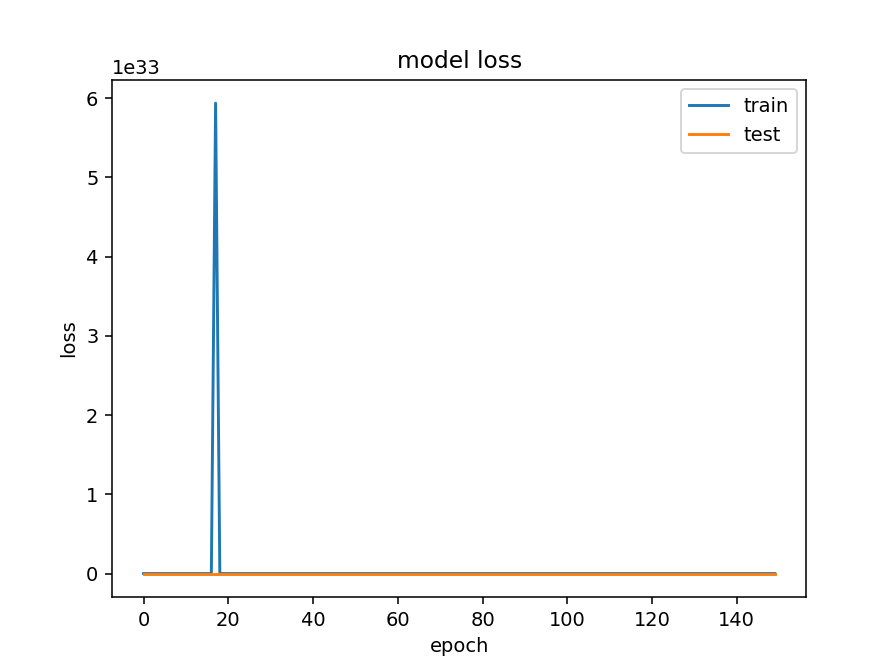

In [256]:
import matplotlib.pyplot as plt
plt.plot(histories.history['loss'])
plt.plot(histories.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


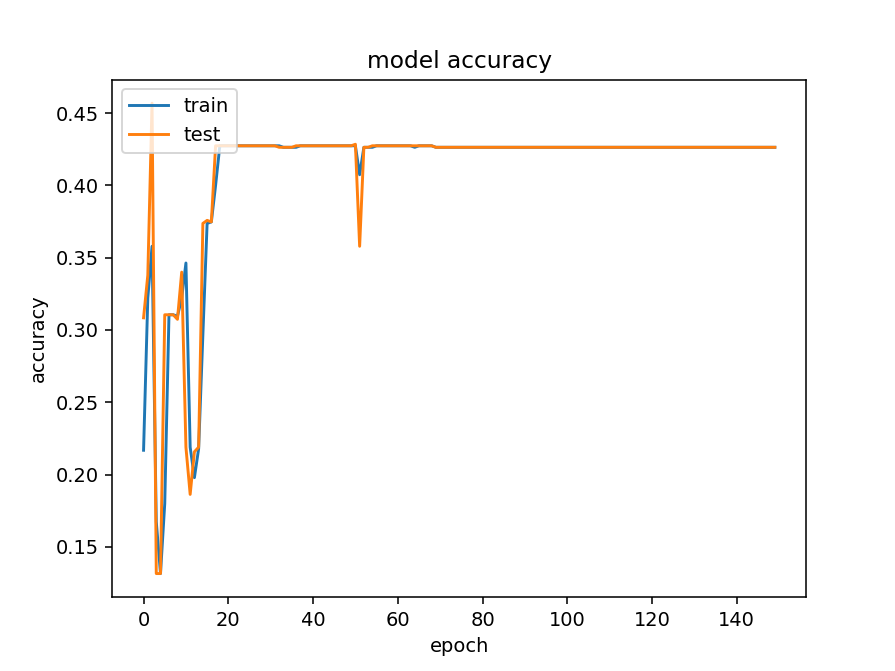

In [257]:
plt.plot(histories.history['acc'])
plt.plot(histories.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()